# Representação de Textos com Embeddings: Word2Vec e BERT

Este notebook apresenta como converter textos em representações numéricas (embeddings) utilizando duas técnicas amplamente usadas:
- **Word2Vec**: Cria representações numéricas para palavras com base no contexto em que aparecem no texto. Utilizaremos a média dos vetores das palavras para representar frases.
- **BERT**: Gera representações de texto considerando o contexto completo da frase, permitindo maior precisão semântica.

## Objetivo
Transformar textos em números para utilizá-los em tarefas de análise, agrupamento e classificação.

## Passo a Passo
1. **Preparar os Dados**: Limpar e pré-processar os textos para deixá-los em um formato adequado.
2. **Gerar Embeddings com Word2Vec**: Criar vetores para cada palavra e, em seguida, combinar os vetores para representar frases.
3. **Gerar Embeddings com BERT**: Usar um modelo pré-treinado para criar vetores que considerem o contexto das frases.
4. **Explorar Aplicações Práticas**: Mostrar como os embeddings podem ser usados para agrupar ou analisar similaridade entre textos.

    

---
---

## Importação de Bibliotecas e Carregamento de Dados
Nesta etapa, utilizamos as bibliotecas necessárias para manipulação de dados e geração de embeddings:
- **Pandas**: Para carregar e manipular o dataset.
- **Gensim**: Para pré-processamento textual e geração de embeddings com Word2Vec.
- **Numpy**: Para cálculos numéricos.
- **Transformers e Torch**: Para geração de embeddings com o modelo BERT.

O dataset contém descrições de reclamações que serão processadas ao longo do notebook.
A seguir, carregamos o dataset e visualizamos suas primeiras linhas.

Obs: Lembrar de instalar as bibliotecas. Como por exemplo 'pip install transformers torch' para a 'transformers'.


In [25]:
import pandas as pd
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
import numpy as np
from transformers import BertTokenizer, BertModel
import torch

# Carregar o dataset
data = pd.read_csv('reclamações.csv')

# Exibir as primeiras linhas
data.head(5)

,id,nome_reclamante,email_reclamante,telefone_reclamante,tipo_reclamacao,sentimento,emocao/emocao,cidade,rua,bairro,estado,data_submissao,data_resposta,categoria,descricao,emocao
0,1,Maria Santos,maria.santos@email.com,(84) 99876-5432,Reclamação,negative,frustration,Natal,Rua das Acácias,Alecrim,RN,2024-10-10,2024-10-15,Iluminação Pública,"A rua está muito escura há semanas, com postes...",NaN
1,2,João Oliveira,joao.oliveira@email.com,(84) 98765-4321,Demanda,neutral,indifference,Parnamirim,Av. Bernardo Vieira,Cohabinal,RN,2024-10-11,2024-10-16,Limpeza Urbana,"Há lixo acumulado na avenida principal, o que ...",NaN
2,3,Carla Farias,carla.farias@email.com,(84) 98888-7777,Sugestão,positive,hope,Natal,Rua dos Cravos,Tirol,RN,2024-10-12,2024-10-17,Saúde Pública,Seria ótimo ampliar o horário de atendimento n...,NaN
3,4,Pedro Alencar,pedro.alencar@email.com,(84) 99999-6666,Reclamação,negative,anger,Mossoró,Rua Santa Luzia,Centro,RN,2024-10-13,2024-10-18,Distribuição de Água,"A falta de água no bairro é constante, ficamos...",NaN
4,5,Ana Lima,ana.lima@email.com,(84) 98765-1234,Demanda,negative,annoyance,Natal,Av. Prudente de Morais,Lagoa Nova,RN,2024-10-14,2024-10-19,Manutenção de Vias Públicas,Há buracos na rua que estão aumentando com o t...,NaN


## Preparo dos Dados
Os textos precisam ser limpos e pré-processados antes de serem convertidos em embeddings. 
Isso inclui:
- Remover pontuação e caracteres especiais.
- Converter tudo para minúsculas.
- Preencher valores ausentes.
- Divide o texto em uma lista de palavras.

### Exemplo
- **Entrada**: `"A rua está muito escura, com postes quebrados!"`
- **Saída**: `["rua", "está", "muito", "escura", "com", "postes", "quebrados"]`



### Por que isso é importante?
O Word2Vec trabalha diretamente com listas de palavras, não com frases completas. 
- Essa etapa padroniza os textos, eliminando inconsistências e ruídos, como letras maiúsculas ou pontuação.
- Garante que o modelo receba dados consistentes e adequados para o treinamento.


## Por que é necessário?

- Word2Vec: Trabalha com listas de palavras. Sem pré-processar, palavras com caracteres especiais ou maiúsculas seriam tratadas como diferentes, mesmo sendo semanticamente iguais. Exemplo: "Casa." e "casa" seriam diferentes sem a limpeza.
- BERT: Embora aceite texto puro, fornecer textos bem formatados melhora o desempenho e evita ruídos desnecessários.
    

In [26]:
# Preenchendo valores ausentes
data['descricao'] = data['descricao'].fillna('Texto ausente')

# Pré-processando os textos
data['descricao_preprocessada'] = data['descricao'].apply(simple_preprocess)

# Visualizar o resultado
data[['descricao', 'descricao_preprocessada']].head()

,descricao,descricao_preprocessada
0,"A rua está muito escura há semanas, com postes...","[rua, está, muito, escura, há, semanas, com, p..."
1,"Há lixo acumulado na avenida principal, o que ...","[há, lixo, acumulado, na, avenida, principal, ..."
2,Seria ótimo ampliar o horário de atendimento n...,"[seria, ótimo, ampliar, horário, de, atendimen..."
3,"A falta de água no bairro é constante, ficamos...","[falta, de, água, no, bairro, constante, ficam..."
4,Há buracos na rua que estão aumentando com o t...,"[há, buracos, na, rua, que, estão, aumentando,..."


---
---
---
# Word2Vec

## Geração de Embeddings com Word2Vec
Word2Vec aprende representações vetoriais de palavras com base em seu contexto. Aqui, usaremos a biblioteca `gensim` para:
1. Treinar um modelo Word2Vec com os textos pré-processados.
2. Calcular a média dos embeddings das palavras para representar cada texto como um vetor.

## Treinamento do Modelo Word2Vec
Nesta etapa, treinaremos um modelo Word2Vec para aprender representações vetoriais (embeddings) das palavras no dataset.

### O que é Word2Vec?
Word2Vec aprende representações vetoriais para palavras com base em seu contexto nos textos. Ele utiliza redes neurais para mapear palavras para um espaço vetorial, onde:
- Palavras com significados semelhantes ficam próximas.
- Palavras frequentemente usadas no mesmo contexto compartilham características nos vetores.

### Parâmetros do Modelo
Ao treinar o modelo, utilizamos os seguintes parâmetros:
1. **`sentences`**: Os textos pré-processados como listas de palavras.
2. **`vector_size`**: O tamanho (dimensão) dos vetores gerados (definido como 100 neste exemplo).
3. **`window`**: O número de palavras ao redor de cada palavra considerada como contexto.
4. **`min_count`**: Frequência mínima para que uma palavra seja incluída no modelo.
5. **`workers`**: Número de threads para paralelizar o treinamento.


### Geração de Embeddings para Textos
Após treinar o modelo, calculamos embeddings para frases completas, tomando a média dos vetores das palavras de cada frase.


In [27]:
# Treinar o modelo Word2Vec
model_w2v = Word2Vec(
    sentences=data['descricao_preprocessada'],  # Lista de listas de palavras (textos pré-processados)
    vector_size=100,  # Dimensão dos vetores gerados para cada palavra
    window=4,  # Número de palavras ao redor de uma palavra (contexto)
    min_count=1,  # Palavras com frequência menor que 1 são ignoradas
    workers=4  # Número de threads para paralelizar o treinamento
)



### Código para Codificar uma Palavra com o Modelo Treinado

In [7]:
# Palavra alvo
target_word = "ônibus"

# Verificar se a palavra está no vocabulário do modelo treinado
if target_word in model_w2v.wv:
    # Obter o vetor da palavra
    word_vector = model_w2v.wv[target_word]
    print(f"Vetor da palavra '{target_word}':\n{word_vector}")
    print(f"Dimensão do vetor: {len(word_vector)}")
else:
    print(f"A palavra '{target_word}' não está no vocabulário do modelo treinado.")


Vetor da palavra 'ônibus':
[ 5.6543113e-03 -7.1179955e-03  7.2417562e-03 -5.5009012e-05
  8.9719035e-03 -9.9166613e-03  2.6520151e-03 -6.6993390e-03
 -4.9830116e-03  5.1780944e-03  3.6785128e-03 -2.1121069e-03
 -8.0498224e-03  9.3793850e-03  6.9930796e-03  4.7510089e-03
 -8.1192823e-03 -7.0122629e-03  5.5079687e-05  3.7518985e-06
 -8.6381305e-03  6.7653758e-03  1.0063849e-02 -5.6758686e-03
  5.0846287e-03 -2.9710814e-04  8.1258547e-03  8.4702745e-03
  1.3089372e-03 -2.0621687e-03  6.3250889e-03 -2.2665581e-03
  6.5210401e-03 -4.3464121e-03  1.8704574e-03  6.7959488e-03
  2.6597362e-03 -2.6602476e-04 -7.1212850e-03 -3.7020424e-03
 -8.8573741e-03  7.5549120e-03  2.8172422e-03  9.1977296e-03
  7.1068476e-03  3.5121869e-03  2.0334378e-03 -7.0608859e-03
  3.0126232e-03  2.2871143e-03 -6.8162079e-04 -5.5881105e-03
 -8.6056972e-03  4.5064888e-03  1.3155978e-03  2.3840894e-03
  6.9060340e-03  5.1911487e-03 -6.6636172e-03  1.8694571e-03
 -7.6599112e-03  4.0149591e-03 -1.4002691e-03  9.3492921e-

### Código para Buscar Palavras Semelhantes

In [28]:
# Função para buscar palavras semelhantes
def get_similar_words(word, model, topn=2):
    """
    Retorna as palavras mais semelhantes a uma palavra no vocabulário do modelo.
    Se a palavra não estiver no vocabulário, retorna uma mensagem informando.
    """
    if word in model.wv:
        similar_words = model.wv.most_similar(word, topn=topn)  # Busca as palavras mais semelhantes usando similaridade
        return similar_words
    else:
        return f"A palavra '{word}' não está no vocabulário do modelo."

# Palavra alvo
target_word = "ônibus"

# Buscar palavras semelhantes
similar_words = get_similar_words(target_word, model_w2v)

# Exibir o resultado
print(f"Palavras semelhantes a '{target_word}':")
print(similar_words)


Palavras semelhantes a 'ônibus':
[('assaltos', 0.3166886270046234), ('cheiro', 0.28866249322891235)]


#### Para criar um plot visual 2D mostrando a palavra buraco, seus vizinhos mais próximos e algumas palavras mais distantes, usaremos PCA (Principal Component Analysis) para reduzir os vetores de 100 dimensões para 2 dimensões.

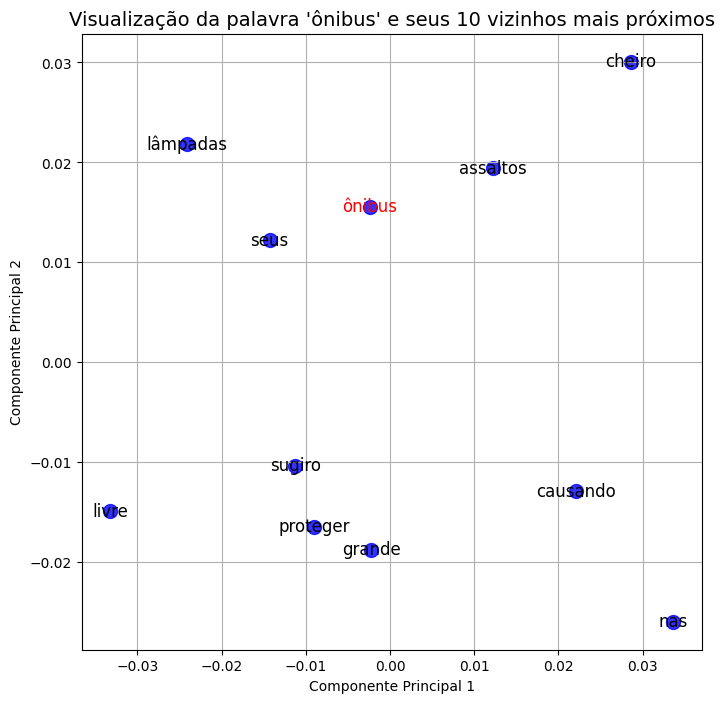

In [29]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Palavra alvo
target_word = "ônibus"

# Obter palavras mais próximas
if target_word in model_w2v.wv:
    similar_words = model_w2v.wv.most_similar(target_word, topn=10)  # Top 10 palavras semelhantes
    similar_words = [word for word, _ in similar_words]  # Apenas as palavras

    # Combinar a palavra alvo com os vizinhos
    plot_words = [target_word] + similar_words
    plot_vectors = [model_w2v.wv[word] for word in plot_words]  # Vetores correspondentes

    # Reduzir para 2D com PCA
    pca = PCA(n_components=2)
    vectors_2d = pca.fit_transform(plot_vectors)

    # Plotar
    plt.figure(figsize=(8, 8))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.8, s=100, c='blue')

    # Adicionar rótulos às palavras com melhor posicionamento
    for i, word in enumerate(plot_words):
        plt.text(vectors_2d[i, 0], vectors_2d[i, 1], word, fontsize=12, 
                 ha='center', va='center', color='red' if word == target_word else 'black')

    # Configurar título e eixos
    plt.title(f"Visualização da palavra '{target_word}' e seus 10 vizinhos mais próximos", fontsize=14)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.grid(True)
    plt.show()
else:
    print(f"A palavra '{target_word}' não está no vocabulário do modelo.")


### Exemplo de greração de uma frase-vetor usando média dos embeddings

**Função `get_text_embedding`**:
   - A função recebe como entrada:
     - O texto pré-processado (uma lista de palavras).
     - O modelo Word2Vec treinado.
   - Para cada palavra no texto:
     - Busca o vetor correspondente no modelo, caso a palavra esteja no vocabulário.
   - Calcula a **média dos vetores das palavras**:
     - Isso gera um vetor único que representa o texto completo.
   - Caso nenhuma palavra do texto esteja no vocabulário:
     - Retorna um vetor de zeros (vetor nulo) como fallback.

In [10]:
# Função para gerar o embedding de um texto
def get_text_embedding(text, model):
    """
    Gera o embedding para um texto completo.
    - Para cada palavra do texto, busca o vetor correspondente no modelo.
    - Calcula a média dos vetores das palavras para criar o vetor do texto.
    - Retorna um vetor nulo se nenhuma palavra do texto estiver no vocabulário do modelo.
    """
    embeddings = [model.wv[word] for word in text if word in model.wv]  # Busca os vetores das palavras no modelo
    if embeddings:
        return np.mean(embeddings, axis=0)  # Retorna a média dos vetores das palavras
    else:
        return np.zeros(model.vector_size)  # Vetor nulo se nenhuma palavra estiver no vocabulário

# Aplicar a função aos textos
data['embedding_w2v'] = data['descricao_preprocessada'].apply(
    lambda x: get_text_embedding(x, model_w2v)  # Calcula o embedding para cada texto
)

# Exibir exemplos dos textos originais, pré-processados e seus embeddings
data[['descricao', 'descricao_preprocessada', 'embedding_w2v']].head()


,descricao,descricao_preprocessada,embedding_w2v
0,"A rua está muito escura há semanas, com postes...","[rua, está, muito, escura, há, semanas, com, p...","[-0.0005922941, 0.0028948148, -0.0023671987, 1..."
1,"Há lixo acumulado na avenida principal, o que ...","[há, lixo, acumulado, na, avenida, principal, ...","[-0.0014958562, 0.003436128, -0.00065957167, 0..."
2,Seria ótimo ampliar o horário de atendimento n...,"[seria, ótimo, ampliar, horário, de, atendimen...","[0.00021744234, 0.0018926658, -0.0010919175, 0..."
3,"A falta de água no bairro é constante, ficamos...","[falta, de, água, no, bairro, constante, ficam...","[0.0010400093, 0.0022132804, -0.002903265, -0...."
4,Há buracos na rua que estão aumentando com o t...,"[há, buracos, na, rua, que, estão, aumentando,...","[-0.001169124, 0.0030155918, -0.0029807915, 0...."


### Plot 2D das paravras com redução de dimensionalidade

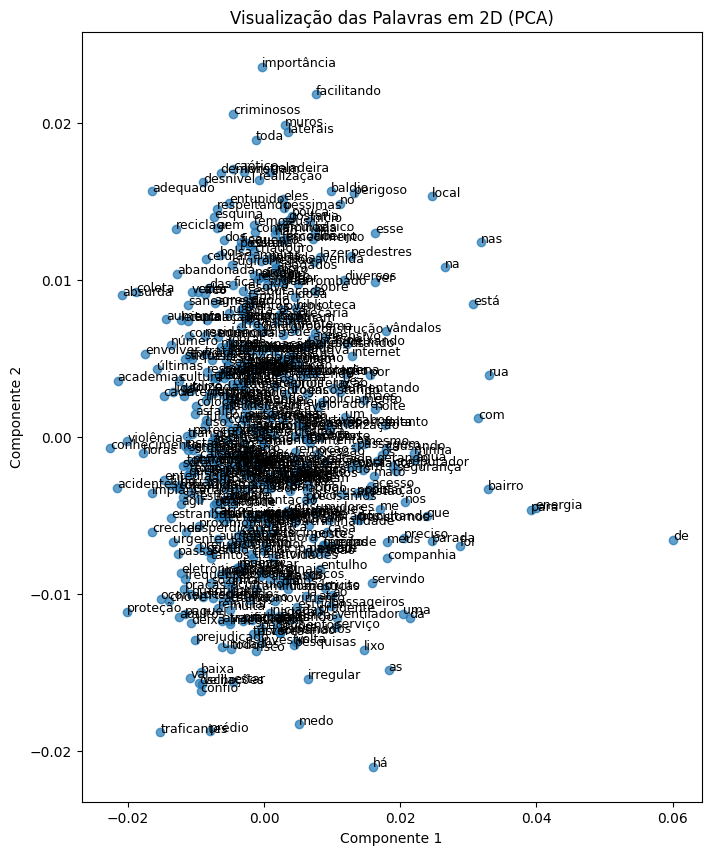

In [30]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Obter as palavras e seus embeddings do modelo Word2Vec
words = list(model_w2v.wv.index_to_key)  # Todas as palavras no vocabulário
word_vectors = model_w2v.wv[words]       # Vetores associados às palavras

# Reduzir para 2D com PCA
pca = PCA(n_components=2)
word_vectors_2d = pca.fit_transform(word_vectors)

# Plotar as palavras em 2D
plt.figure(figsize=(8, 10))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], alpha=0.7)

# Adicionar as palavras como texto no gráfico
for i, word in enumerate(words):
    plt.text(word_vectors_2d[i, 0], word_vectors_2d[i, 1], word, fontsize=9)

plt.title("Visualização das Palavras em 2D (PCA)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()


### Plot 3D das paravras com redução de dimensionalidade

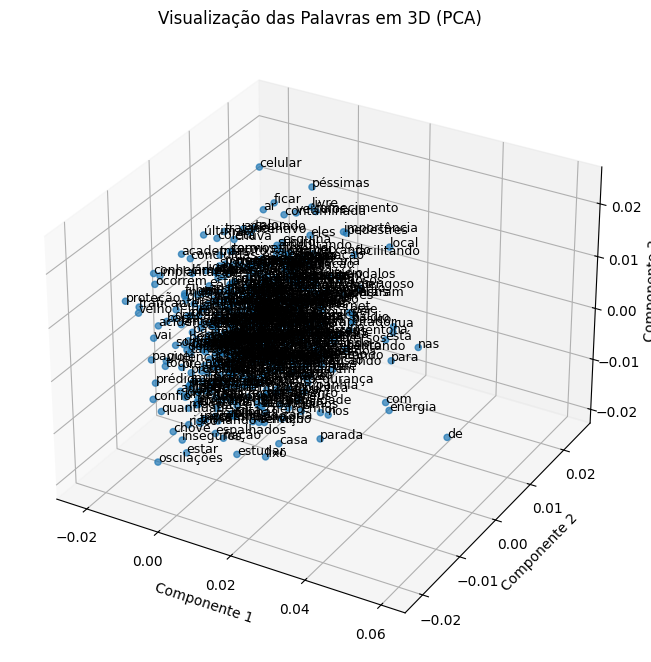

In [31]:
from mpl_toolkits.mplot3d import Axes3D

# Reduzir para 3D com PCA
pca = PCA(n_components=3)
word_vectors_3d = pca.fit_transform(word_vectors)

# Plotar as palavras em 3D
fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(word_vectors_3d[:, 0], word_vectors_3d[:, 1], word_vectors_3d[:, 2], alpha=0.7)

# Adicionar as palavras como texto no gráfico
for i, word in enumerate(words):
    ax.text(word_vectors_3d[i, 0], word_vectors_3d[i, 1], word_vectors_3d[i, 2], word, fontsize=9)

ax.set_title("Visualização das Palavras em 3D (PCA)")
ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
ax.set_zlabel("Componente 3")
plt.show()


## Representação de Frases com a Média dos Vetores das Palavras

### O que é?
Ao representar uma frase, podemos calcular a **média dos vetores das palavras** que a compõem. Essa técnica é simples e eficiente, sendo amplamente utilizada em tarefas básicas de NLP.

### Por que usar?
1. **Simplicidade**: Fácil de implementar e rápido para calcular.
2. **Eficiência**: Computacionalmente leve, ideal para tarefas simples.
3. **Significado Geral**: Captura o "significado médio" das palavras na frase.

### Limitações
1. **Perda de Ordem**: Ignora a ordem das palavras, o que pode alterar o significado.
   - Exemplo: "O gato comeu o rato" ≠ "O rato comeu o gato".
2. **Peso Igual para Palavras**: Todas as palavras são tratadas com a mesma importância, mesmo as menos relevantes (ex.: artigos).
3. **Vocabulário Limitado**: Palavras fora do vocabulário do modelo são ignoradas.


---
---
---

## Geração de Embeddings com BERT

### O que é BERT?
**BERT** (*Bidirectional Encoder Representations from Transformers*) é um modelo baseado em transformadores que captura o contexto completo de palavras e frases, levando em contvras.

### Por que usar BERT?
- **Contexto rico**: Captura significados contextuais detalhados, o que torna os embeddings mais precisos.
- **Flexibilidade**: Pode ser usado para tarefas em nível de palavra, frase ou documento.
- **Bidirecionalidade**: Lê o texto em ambas as direções (esquerda para direita e vice-versa).

### Modelo Utilizado
Usaremos o modelo pré-treinado `bert-base-uncased` da biblioteca Hugging Face:
- **Pré-treinado** em um grande corpus de texto (livros e Wikipedia).
- **Uncased**: Não diferencia letras maiúsculas e minúsculas, ideal para muitas aplicações em inglês.
ilizar o modelo BERT para gerar embeddings.
2. Obter representações em **nível de frase** (vetores que representam o significado da frase completa).

---

### Etapas
1. **Tokenização**:
   - Convertemos o texto em tokens que BERT pode entender.
   - Adicionamos tokens especiais (ex.: `[CLS]` e `[SEP]`) para sinalizar o início e o final da frase.

2. **Processamento pelo Modelo**:
   - Passamos os tokens pelo modelo BERT para obter os embeddings.
   - Utilizamos o vetor correspondente ao token `[CLS]` como representação da frase.

3. **Resultado**:
   - Geramos um vetor único (embedding) para cada frase, que pode ser usado em diversas tarefas de NLP.

    

---
---

## Pré-processamento para BERT

### Objetivo
Antes de usar o modelo BERT, precisamos preparar o texto para que seja compatível com o formato de entrada do modelo. O pré-processamento inclui:
1. **Preencher valores ausentes**: Substituir textos vazios por um valor padrão.
2. **Usar o tokenizador do BERT**: Ele automaticamente:
   - Divide o texto em tokens apropriados.
   - Converte os tokens em IDs numéricos compatíveis com o modelo.
   - Adiciona tokens especiais `[CLS]` (início da frase) e `[SEP]` (fim da frase).


In [13]:
import pandas as pd
from transformers import BertTokenizer

# Carregar o dataset
data = pd.read_csv('reclamações.csv')

# Preencher valores ausentes com texto padrão
data['descricao'] = data['descricao'].fillna('Texto ausente')

# Filtrar textos irrelevantes ("Texto ausente")
data = data[data['descricao'] != "Texto ausente"]

# Carregar o tokenizador do modelo BERT (inglês)
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Carregar o tokenizador do modelo BERT (português)
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')


# Pré-processar o texto para o formato do BERT
def preprocess_for_bert(text, tokenizer):
    """
    Pré-processa o texto para o modelo BERT:
    - Tokeniza o texto.
    - Retorna os IDs dos tokens.
    """
    # Tokenizar e converter para IDs numéricos
    tokens = tokenizer(text, truncation=True, padding='max_length', max_length=512, return_tensors='pt')
    return tokens['input_ids'], tokens['attention_mask']

# Aplicar o pré-processamento em cada texto
data['tokens'], data['attention_masks'] = zip(*data['descricao'].apply(lambda x: preprocess_for_bert(x, tokenizer)))

# Converter tensores para listas para exibição
data['tokens_readable'] = data['tokens'].apply(lambda x: x[0].tolist())
data['attention_masks_readable'] = data['attention_masks'].apply(lambda x: x[0].tolist())

# Exibir uma amostra com tokens e máscaras convertidos
data[['descricao', 'tokens_readable', 'attention_masks_readable']].head()

,descricao,tokens_readable,attention_masks_readable
0,"A rua está muito escura há semanas, com postes...","[101, 177, 4768, 698, 785, 15357, 1307, 3765, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"Há lixo acumulado na avenida principal, o que ...","[101, 3074, 14575, 6039, 2794, 229, 11810, 131...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,Seria ótimo ampliar o horário de atendimento n...,"[101, 2285, 151, 20576, 17086, 146, 7356, 125,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"A falta de água no bairro é constante, ficamos...","[101, 177, 3207, 125, 1991, 202, 2907, 253, 40...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,Há buracos na rua que estão aumentando com o t...,"[101, 3074, 21056, 229, 4768, 179, 1376, 10479...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


### **Resumo das Colunas**

| Coluna                   | O que é?                                                                | Por que é importante?                                                                |
|--------------------------|-------------------------------------------------------------------------|--------------------------------------------------------------------------------------|
| `descricao`              | Texto original do dataset.                                             | É a base do processo e nos ajuda a entender o que está sendo analisado.             |
| `tokens_readable`        | Texto convertido em IDs de tokens para o modelo.                       | O modelo BERT usa esses números para calcular os embeddings.                        |
| `attention_masks_readable` | Máscara que diferencia tokens válidos de preenchimento.               | Garante que o modelo processe apenas os tokens que pertencem ao texto original.     |


## Geração de Embeddings com o Modelo BERT

### O que estamos fazendo?
Nesta etapa, utilizamos o modelo **BERT pré-treinado** para gerar embeddings (representações vetoriais) das frases do dataset. Esses embeddings são vetores de 768 dimensões que capturam o significado e contexto completo de cada frase.

---

### Como funciona?
1. **Entrada**:
   - Utilizamos os tokens (`tokens_readable`) e as máscaras de atenção (`attention_masks`) gerados na etapa anterior.
   - Os tokens representam o texto em formato numérico, e as máscaras indicam quais partes do texto são válidas (não são padding).

2. **Processamento no Modelo BERT**:
   - Passamos os tokens e as máscaras pelo modelo BERT.
   - Extraímos o vetor associado ao token especial `[CLS]`.
     - Este vetor captura o contexto geral da frase e é usado como sua representação.

3. **Saída**:
   - Cada frase do dataset é representada por um vetor de 768 dimensões.
   - Esses vetores podem ser usados para tarefas como classificação, clustering ou análise de similaridade.

---

### Por que usar o vetor `[CLS]`?
- O token `[CLS]` é projetado para capturar o significado global da frase.
- Durante o treinamento do BERT, o vetor `[CLS]` é ajustado para ser uma boa representação da sequência inteira de tokens.

---

### Estrutura do Código
1. **Função `get_bert_embedding`**:
   - Recebe os tokens e as máscaras de atenção de uma frase.
   - Passa esses valores pelo modelo BERT.
   - Retorna o vetor `[CLS]` como o embedding da frase.

2. **Aplicação ao Dataset**:
   - A função é aplicada a cada linha do dataset.
   - Os embeddings gerados são armazenados na coluna `embedding_bert`.

---

### Exemplo de Saída

| descricao                         | embedding_bert                   |
|-----------------------------------|----------------------------------|
| "Há buracos na rua que estão..."  | `[0.56, -0.34, 1.12, ..., 0.87]`|
| "Produto chegou quebrado."        | `[0.23, 0.54, -0.87, ..., 1.02]`|



In [15]:
from transformers import BertModel
import torch

# Carregar o modelo BERT pré-treinado (em inglês)
#model = BertModel.from_pretrained('bert-base-uncased')

# Carregar o modelo BERT pré-treinado (em português)
model = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

# Função para gerar embeddings usando o modelo BERT
def get_bert_embedding(tokens, attention_mask, model):
    """
    Gera o embedding para uma frase:
    - Recebe tokens e máscaras de atenção.
    - Passa pelos layers do modelo BERT.
    - Usa o vetor [CLS] como representação do texto.
    """
    # Passar os tokens e a máscara pelo modelo
    with torch.no_grad():
        outputs = model(input_ids=tokens, attention_mask=attention_mask)
    
    # Obter o vetor [CLS] da saída
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # Shape: (batch_size, 768)
    return cls_embedding.squeeze().numpy()  # Converter para numpy

# Gerar embeddings para cada linha do dataset
data['embedding_bert'] = data.apply(
    lambda row: get_bert_embedding(row['tokens'], row['attention_masks'], model),
    axis=1
)

# Exibir os resultados
data[['descricao', 'embedding_bert']].head(5)


,descricao,embedding_bert
0,"A rua está muito escura há semanas, com postes...","[0.1393002, -0.26347065, 0.41958004, -0.195754..."
1,"Há lixo acumulado na avenida principal, o que ...","[0.23760852, -0.19924447, 0.4508139, -0.261496..."
2,Seria ótimo ampliar o horário de atendimento n...,"[0.14516374, -0.101525724, 0.4707241, 0.056136..."
3,"A falta de água no bairro é constante, ficamos...","[0.12155067, -0.36352292, 0.5335672, -0.107120..."
4,Há buracos na rua que estão aumentando com o t...,"[0.25584823, 0.07755148, 0.52996314, 0.0047344..."


### Nesta etapa, o código busca no dataset os trechos mais relacionados à palavra **"ônibus"** com base na similaridade semântica.

---

### Como funciona?
1. Vetoriza a palavra **"ônibus"** usando o modelo BERT.
2. Calcula os embeddings para cada trecho do dataset (já pré-processado na etapa anterior).
3. Compara os vetores do dataset com o vetor de **"ônibus"** usando **similaridade de cosseno**.
4. Ordena os trechos do mais semelhante ao menos semelhante e exibe os dois mais próximos.


In [16]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch

# Função para gerar embeddings usando tokens e máscaras já existentes
def get_embedding_from_tokens(tokens, attention_mask, model):
    """
    Gera o embedding para um texto usando tokens e máscaras já calculados.
    """
    with torch.no_grad():
        outputs = model(input_ids=tokens, attention_mask=attention_mask)
    # Obter o vetor [CLS] como a representação do texto
    cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()  # Pega o [CLS]
    return cls_embedding.squeeze()

# Vetorizar a palavra "ônibus"
target_word = "ônibus"
target_inputs = tokenizer(target_word, return_tensors='pt', truncation=True, padding=True, max_length=512)
target_embedding = get_embedding_from_tokens(
    target_inputs['input_ids'], target_inputs['attention_mask'], model
)

# Calcular os embeddings para cada texto do dataset
data['bert_embedding'] = data.apply(
    lambda row: get_embedding_from_tokens(row['tokens'], row['attention_masks'], model),
    axis=1
)

# Calcular similaridades com a palavra "ônibus"
data['similarity_to_onibus'] = data['bert_embedding'].apply(
    lambda x: cosine_similarity([target_embedding], [x])[0, 0]
)

# Ordenar pelo grau de similaridade
most_similar = data[['descricao', 'similarity_to_onibus']].sort_values(
    by='similarity_to_onibus', ascending=False
)

# Exibir os dois vizinhos mais próximos
print("Vizinhos mais próximos de 'ônibus':")
print(most_similar.head(2))


Vizinhos mais próximos de 'ônibus':
                                            descricao  similarity_to_onibus
34  O trânsito na avenida principal está caótico n...              0.721866
6   O trânsito na cidade está cada vez mais caótic...              0.689234


## Visualização dos vizinhos usando redução de dimensionalidade

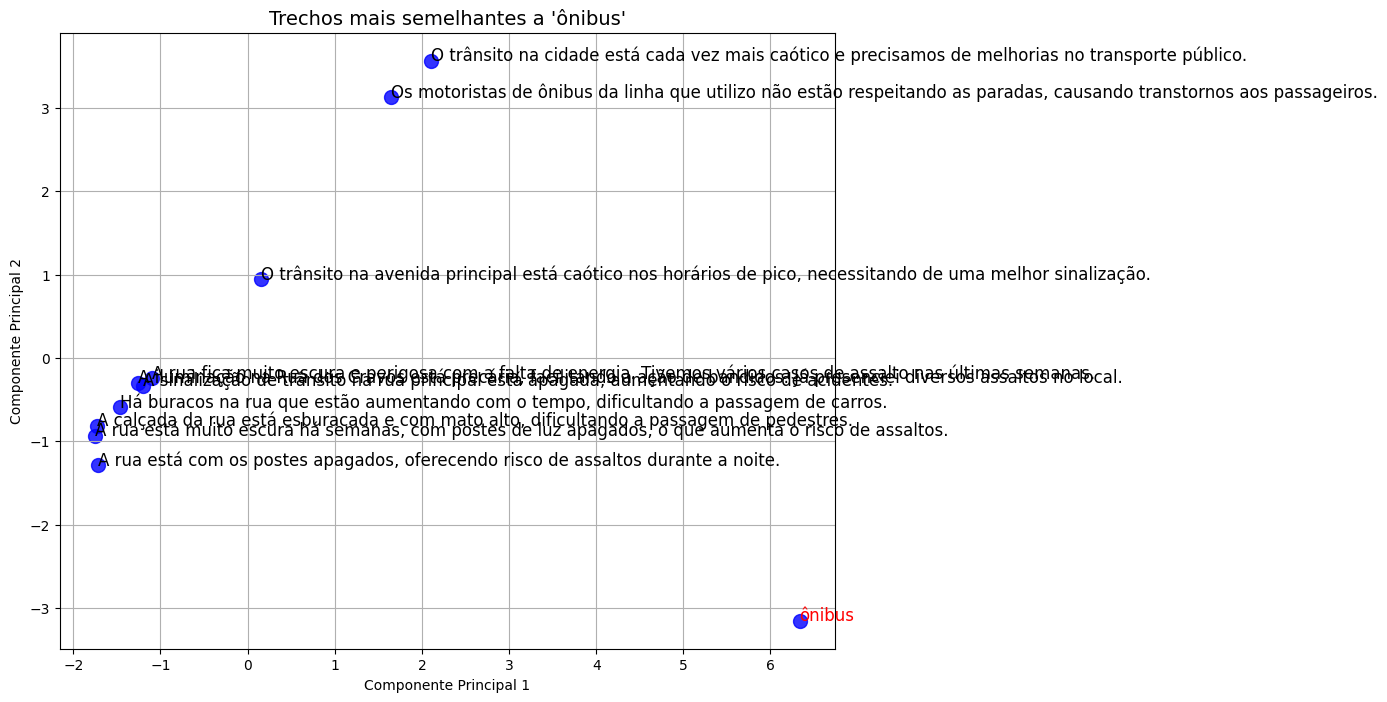

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduzir para 2D usando PCA
def plot_similarity(data, target_word, top_n=10):
    """
    Plota os trechos mais semelhantes ao target_word em 2D.
    """
    # Filtrar os trechos mais semelhantes
    top_similar = data[['descricao', 'bert_embedding', 'similarity_to_onibus']].sort_values(
        by='similarity_to_onibus', ascending=False
    ).head(top_n)

    # Embeddings e descrições
    embeddings = np.array(top_similar['bert_embedding'].tolist())
    descriptions = top_similar['descricao'].tolist()
    
    # Adicionar o vetor da palavra-alvo
    embeddings = np.vstack([target_embedding, embeddings])
    descriptions = [target_word] + descriptions

    # Reduzir dimensões para 2D
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Plotar
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='blue', alpha=0.8, s=100)

    for i, text in enumerate(descriptions):
        color = 'red' if i == 0 else 'black'  # Destacar a palavra-alvo
        plt.text(reduced_embeddings[i, 0], reduced_embeddings[i, 1], text, fontsize=12, color=color)
    
    plt.title(f"Trechos mais semelhantes a '{target_word}'", fontsize=14)
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.grid(True)
    plt.show()

# Chamar a função para plotar
plot_similarity(data, "ônibus", top_n=10)


In [20]:
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Modelo BERT para português
tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
model = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

# Dados para treinamento do Word2Vec
sentences = [
    ["Eu", "fui", "ao", "banco", "sacar", "dinheiro"],
    ["Eu", "sentei", "no", "banco", "do", "parque"]
]

# Treinando Word2Vec
model_w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Função para obter o embedding de uma palavra usando Word2Vec
def get_word2vec_embedding(word, model):
    if word in model.wv:
        return model.wv[word]
    else:
        return None

# Função para obter o embedding contextualizado usando BERT
def get_contextual_embedding(text, target_word, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Obter o índice do token correspondente à palavra
    token_index = tokenizer.encode(text, add_special_tokens=True).index(tokenizer.encode(target_word, add_special_tokens=False)[0])
    token_embedding = outputs.last_hidden_state[0, token_index, :].numpy()
    return token_embedding

# Frases com diferentes contextos para a palavra "banco"
sentence1 = "Eu fui ao banco sacar dinheiro."
sentence2 = "Eu sentei no banco do parque."

# Obter embeddings de Word2Vec
embedding_w2v_1 = get_word2vec_embedding("banco", model_w2v)
embedding_w2v_2 = get_word2vec_embedding("banco", model_w2v)

# Obter embeddings de BERT
embedding_bert_1 = get_contextual_embedding(sentence1, "banco", tokenizer, model)
embedding_bert_2 = get_contextual_embedding(sentence2, "banco", tokenizer, model)

# Calcular similaridade para Word2Vec e BERT
similarity_w2v = cosine_similarity([embedding_w2v_1], [embedding_w2v_2])[0, 0]
similarity_bert = cosine_similarity([embedding_bert_1], [embedding_bert_2])[0, 0]

# Resultados
print(f"Similaridade para Word2Vec (mesmo vetor para 'banco'): {similarity_w2v:.4f}")
print(f"Similaridade para BERT (contexto específico): {similarity_bert:.4f}")



Similaridade para Word2Vec (mesmo vetor para 'banco'): 1.0000
Similaridade para BERT (contexto específico): 0.6705



### Exemplo de saída com o bert-base-uncased treinado em inglês
-- Similaridade para Word2Vec (mesmo vetor para 'banco'): 1.0000

-- Similaridade para BERT (contexto específico): 0.9164



---
---
## Recursos para Modelos de Embeddings e Transformers

Aqui estão algumas opções para explorar embeddings e transformers:

- **[Word2Vec no TensorFlow](https://www.tensorflow.org/text/tutorials/word2vec)**:
  Tutorial para treinar e usar Word2Vec com TensorFlow.

- **[Doc2Vec (Gensim)](https://radimrehurek.com/gensim/models/doc2vec.html)**:
  Gera embeddings para documentos inteiros, ideal para frases ou textos longos.

- **[GloVe (Stanford)](https://nlp.stanford.edu/projects/glove/)**:
  Modelo pré-treinado baseado em coocorrência, usado para representar palavras.

- **[MUSE (Facebook)](https://github.com/facebookresearch/MUSE)**:
  Embeddings multilíngues para tradução e tarefas em vários idiomas.

- **[BioBERT](https://pypi.org/project/biobert-embedding/)**:
  Modelo BERT especializado em biomedicina.

---
---